In [16]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

delta=dt.timedelta(days=1)

In [17]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [18]:
fechaIni='2023-11-01'
fechaFin='2025-10-31'
# Consulta la disponibilidad de las plantas en el OFEI
query = f"""
select fechaoperacion, planta, tipo,
hora1, hora2, hora3, hora4, hora5, hora6, hora7, hora8, hora9, hora10, hora11, hora12,
hora13, hora14, hora15, hora16, hora17, hora18, hora19, hora20, hora21, hora22, hora23, hora24
from `enersinc-tbsg-bq`.tbsg.public_ofei
where fechaoperacion >='{fechaIni}' and fechaoperacion <='{fechaFin}' and tipo='D'
and ( planta in ('BARRANQUILLA3 ','BARRANQUILLA4 ','CARTAGENA1 ','CARTAGENA2 ','CARTAGENA3 ','FLORES1GAS ','FLORES1VAPOR ','FLORES2 ','FLORES3 ','FLORES4 ','GUAJIRA1 '
					,'GUAJIRA2 ','PROELECTRICA1 ','PROELECTRICA2 ','TEBSA11 ','TEBSA12 ','TEBSA13 ','TEBSA14 ','TEBSA21 ','TEBSA22 ','TEBSA24 ','TERMOCANDELARIACC1 '
					,'TERMOCANDELARIACC2 ','TERMOCANDELARIACC3 ','TERMOCARIBEIII1 ','TERMONORTE1 ','TERMONORTE10 ','TERMONORTE2 ','TERMONORTE3 ','TERMONORTE4 ','TERMONORTE5 '
					,'TERMONORTE6 ','TERMONORTE7 ','TERMONORTE8 ','TERMONORTE9 ') )
order by fechaoperacion,planta

"""

# Ejecutar la consulta
df_DispUIni = client.query(query).to_dataframe()


In [19]:
# Leer archivo de excel
s_parentpath=Path('C:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython\ArchivosEntrada')
filepath=s_parentpath.joinpath(s_parentpath,'PesoUnidades.xlsx')

# Loas units
sheet_name='PesoUnidad'
df_Peso=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

In [20]:
df_DispU=df_DispUIni.copy()
df_DispU['flag'] = df_DispU.loc[:, 'hora1':'hora24'].apply(lambda row: 0 if (row == 0).any() else 1, axis=1)
df_DispU = df_DispU[['fechaoperacion','planta','flag']]
df_DispU=df_DispU.merge(df_Peso,left_on=['planta'],right_on=['Unidad'],how='inner')[['fechaoperacion','planta','flag','Peso']]
df_DispU['PesoDia']=df_DispU['flag']*df_DispU['Peso']
df_DispU.head(3)
df_DispU.to_csv('DispUnidades.csv')

In [21]:
df_DispU_sinTB=df_DispU.copy()
df_DispU_sinTB = df_DispU_sinTB[~df_DispU_sinTB['planta'].isin(['TEBSA11 ', 'TEBSA12 ', 'TEBSA24 '])]

df_DispU_sinTBF=df_DispU.copy()
df_DispU_sinTBF = df_DispU_sinTBF[~df_DispU_sinTBF['planta'].isin(['TEBSA11 ', 'TEBSA12 ', 'TEBSA24 ','FLORES3 '])]

df_DispU_sinBQs=df_DispU.copy()
df_DispU_sinBQs = df_DispU_sinBQs[~df_DispU_sinBQs['planta'].isin(['BARRANQUILLA3 ', 'BARRANQUILLA4 '])]

df_DispU_sinCtgs=df_DispU.copy()
df_DispU_sinCtgs = df_DispU_sinCtgs[~df_DispU_sinCtgs['planta'].isin(['CARTAGENA1 ','CARTAGENA2 ','CARTAGENA3 ','BARRANQUILLA3 ', 'BARRANQUILLA4 '])]

df_DispU_sinTB.head(10)


,fechaoperacion,planta,flag,Peso,PesoDia
0,2023-11-01,BARRANQUILLA3,1,0.2,0.2
1,2023-11-01,BARRANQUILLA4,1,0.2,0.2
2,2023-11-01,CARTAGENA1,0,0.3,0.0
3,2023-11-01,CARTAGENA2,0,0.3,0.0
4,2023-11-01,CARTAGENA3,0,0.3,0.0
5,2023-11-01,FLORES1GAS,0,0.5,0.0
6,2023-11-01,FLORES1VAPOR,0,0.4,0.0
7,2023-11-01,FLORES2,1,0.6,0.6
8,2023-11-01,FLORES3,1,1.0,1.0
9,2023-11-01,FLORES4,1,1.0,1.0


In [22]:
df_PesoDiaIni = df_DispU.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_PesoDia_SinTB= df_DispU_sinTB.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_DispU_sinTBF= df_DispU_sinTBF.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_DispU_sinBQs= df_DispU_sinBQs.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)
df_DispU_sinCtgs = df_DispU_sinCtgs.groupby('fechaoperacion', as_index=False)['PesoDia'].sum().round(2)

In [23]:
# Valores de umbral
thresholds = [12,11.5,11,10.5,10,9.5,9,8.5,8,7.5,7,6.5,6,5.5,5]

# Calcular probabilidades Inicial
probabilitiesIni = [(df_PesoDiaIni['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinTB = [(df_PesoDia_SinTB['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinTBF = [(df_DispU_sinTBF['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinBQs = [(df_DispU_sinBQs['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Calcular probabilidades Final
probabilities_SinCtgs = [(df_DispU_sinCtgs['PesoDia'] >= threshold).mean() for threshold in thresholds]

# Crear DataFrame con thresholds y probabilities_SinCtgs
df_prob_SinCtgs = pd.DataFrame({
    'thresholds': thresholds,
    'probabilities_SinCtgs': probabilities_SinCtgs
})

# Mostrar el DataFrame
df_prob_SinCtgs



,thresholds,probabilities_SinCtgs
0,12.0,0.689466
1,11.5,0.860465
2,11.0,0.890561
3,10.5,0.954856
4,10.0,0.968536
5,9.5,0.987688
6,9.0,0.987688
7,8.5,0.987688
8,8.0,0.993160
9,7.5,0.993160


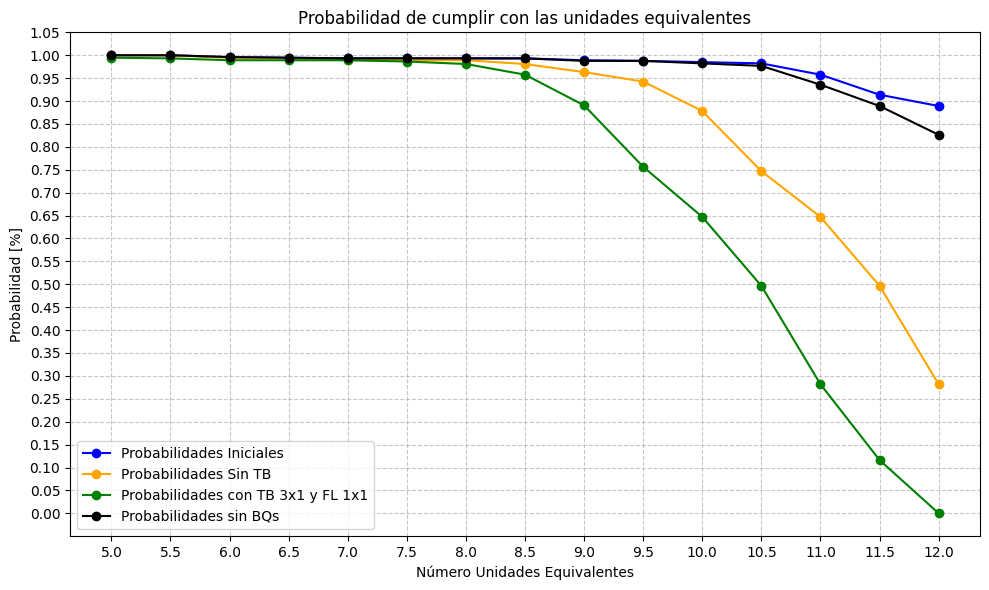

In [24]:
# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.plot(thresholds, probabilitiesIni, marker='o', label='Probabilidades Iniciales', color='blue')
plt.plot(thresholds, probabilities_SinTB, marker='o', label='Probabilidades Sin TB', color='orange')
plt.plot(thresholds, probabilities_SinTBF, marker='o', label='Probabilidades con TB 3x1 y FL 1x1', color='green')
plt.plot(thresholds, probabilities_SinBQs, marker='o', label='Probabilidades sin BQs', color='black')

# Configurar el gráfico
plt.title('Probabilidad de cumplir con las unidades equivalentes')
plt.xlabel('Número Unidades Equivalentes')
plt.ylabel('Probabilidad [%]')
plt.xticks(thresholds)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

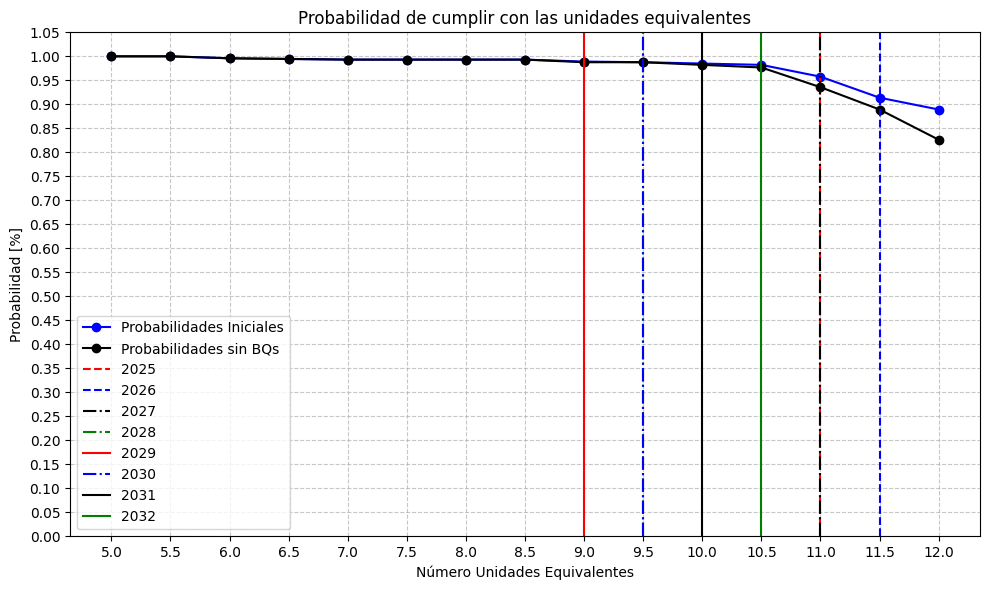

In [25]:
# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.plot(thresholds, probabilitiesIni, marker='o', label='Probabilidades Iniciales', color='blue')
plt.plot(thresholds, probabilities_SinBQs, marker='o', label='Probabilidades sin BQs', color='black')

ax = plt.gca()
# Vertical lines en x=11 (2025) y x=11.5 (2026)
ax.axvline(x=11, color='red', linestyle='--', linewidth=1.5,label='2025')
ax.axvline(x=11.5, color='blue', linestyle='--', linewidth=1.5,label='2026')
ax.axvline(x=11, color='black', linestyle='-.', linewidth=1.5,label='2027')
ax.axvline(x=9.5, color='green', linestyle='-.', linewidth=1.5,label='2028')
ax.axvline(x=9, color='red', linestyle='-', linewidth=1.5,label='2029')
ax.axvline(x=9.5, color='blue', linestyle='-.', linewidth=1.5,label='2030')
ax.axvline(x=10, color='black', linestyle='-', linewidth=1.5,label='2031')
ax.axvline(x=10.5, color='green', linestyle='-', linewidth=1.5,label='2032')


# Configurar el gráfico
plt.title('Probabilidad de cumplir con las unidades equivalentes')
plt.xlabel('Número Unidades Equivalentes')
plt.ylabel('Probabilidad [%]')
plt.xticks(thresholds)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

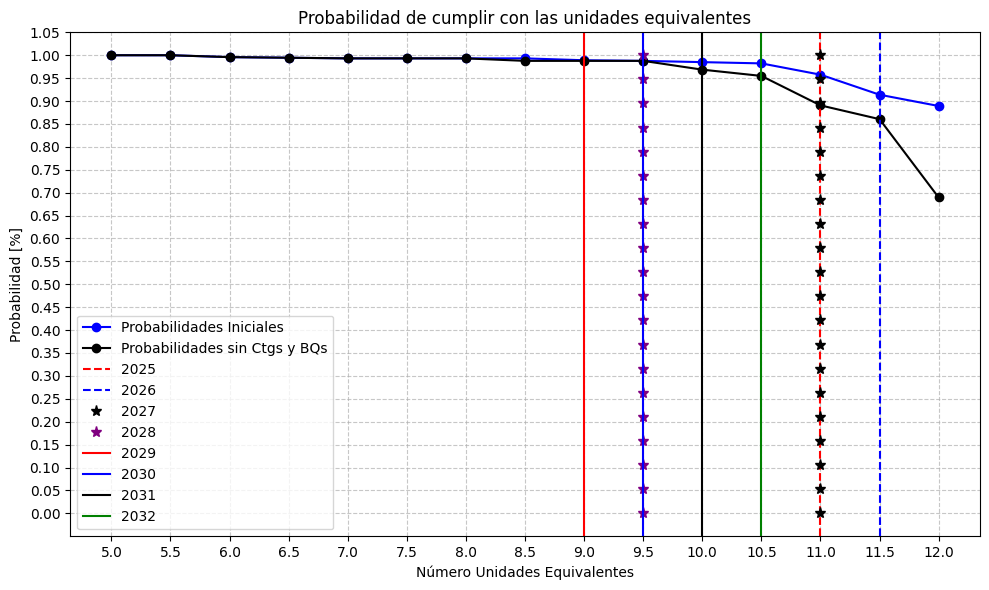

In [26]:
# Graficar las probabilidades
plt.figure(figsize=(10, 6))
plt.plot(thresholds, probabilitiesIni, marker='o', label='Probabilidades Iniciales', color='blue')
plt.plot(thresholds, probabilities_SinCtgs, marker='o', label='Probabilidades sin Ctgs y BQs', color='black')

max2025=11
max2026=11.5
max2027=11
max2028=9.5
max2029=9
max2030=9.5
max2031=10
max2032=10.5

ax = plt.gca()
# Vertical lines en x=11 (2025) y x=11.5 (2026)
ax.axvline(x=max2025, color='red', linestyle='--', linewidth=1.5,label='2025')
ax.axvline(x=max2026, color='blue', linestyle='--', linewidth=1.5,label='2026')

# ax.axvline(x=11, color='black', linestyle='-.', linewidth=1.5,label='2027')
x_pos = max2027
y_vals = np.linspace(0, 1, 20)
ax.plot([x_pos] * len(y_vals), y_vals, marker='*', linestyle='None', color='black', markersize=8, label='2027')

# ax.axvline(x=9.5, color='green', linestyle='-.', linewidth=1.5,label='2028')
# Añadir una línea vertical hecha con '*' en lugar de '--'
x_pos = max2028
y_vals = np.linspace(0, 1, 20)
ax.plot([x_pos] * len(y_vals), y_vals, marker='*', linestyle='None', color='purple', markersize=8, label='2028')

ax.axvline(x=max2029, color='red', linestyle='-', linewidth=1.5,label='2029')
ax.axvline(x=max2030, color='blue', linestyle='-', linewidth=1.5,label='2030')
ax.axvline(x=max2031, color='black', linestyle='-', linewidth=1.5,label='2031')
ax.axvline(x=max2032, color='green', linestyle='-', linewidth=1.5,label='2032')




# Configurar el gráfico
plt.title('Probabilidad de cumplir con las unidades equivalentes')
plt.xlabel('Número Unidades Equivalentes')
plt.ylabel('Probabilidad [%]')
plt.xticks(thresholds)
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [27]:
fechaIni='2023-11-01'
fechaFin='2025-10-31'
# Consulta la disponibilidad de las plantas en el OFEI
query = f"""
select *
from tbsg.public_dsegdes
where fechaoperacion >='2023-01-01' and fechaoperacion <='2025-10-31'
and nombre = 'ZS_CARIBE2'
order by fechaoperacion 
"""

# Ejecutar la consulta
df_UEini = client.query(query).to_dataframe()

In [28]:
# Procesamiento de la información
df_UE=df_UEini.copy()
df_UE['Max24h'] = df_UE.loc[:, 'hora1':'hora24'].max(axis=1)
df_UE=df_UE[['fechaoperacion','Max24h']]
df_UE

,fechaoperacion,Max24h
0,2023-01-01,4.0
1,2023-01-02,5.5
2,2023-01-03,6.0
3,2023-01-04,6.5
4,2023-01-05,6.0
...,...,...
1027,2025-10-27,8.5
1028,2025-10-28,8.5
1029,2025-10-29,9.0
1030,2025-10-30,8.5


In [29]:
import pandas as pd
import numpy as np

# Parámetros
step = 0.5        # paso entre deltas
max_delta = 3.0   # delta máximo

# Asegurar que la fecha sea tipo datetime
df_UE['fechaoperacion'] = pd.to_datetime(df_UE['fechaoperacion'])

# Extraer el año
df_UE['anio'] = df_UE['fechaoperacion'].dt.year

# Calcular el valor máximo de Max24h por año
max_por_anio = df_UE.groupby('anio')['Max24h'].max().rename('Max24h_max')

# Unir para tener el máximo anual en cada fila
df_UE = df_UE.merge(max_por_anio, on='anio', how='left')

# Lista de deltas: 0, 0.5, 1, 1.5, ..., max_delta
deltas = np.round(np.arange(0.0, max_delta + 1e-9, step), 10)

resultados = []

for delta in deltas:
    # Umbral fila a fila = máximo anual - delta
    umbral_serie = df_UE['Max24h_max'] - delta

    # Indicador: 1 si Max24h >= umbral, 0 en otro caso
    indicador = (df_UE['Max24h'] >= umbral_serie).astype(int)

    # Probabilidad por año para ese delta
    prob_por_anio = (
        indicador.groupby(df_UE['anio'])
                 .mean()
                 .rename('probabilidad')
                 .reset_index()
    )

    # Agregar columna delta
    prob_por_anio['delta'] = delta

    # Agregar columna umbral: max_anual(año) - delta
    prob_por_anio['umbral'] = prob_por_anio['anio'].map(max_por_anio) - delta

    resultados.append(prob_por_anio[['anio', 'umbral', 'delta', 'probabilidad']])

# Unir todos los resultados en UN solo DataFrame
prob_delta_anio = pd.concat(resultados, ignore_index=True)

# Ordenar por año y delta
prob_delta_anio = prob_delta_anio.sort_values(['anio', 'delta'])

# Probabilidad de estar en el tramo entre delta anterior y el actual
# S(δ_i) - S(δ_{i-1}) por año
prob_delta_anio['prob_tramo'] = (
    prob_delta_anio
    .groupby('anio')['probabilidad']
    .diff()
)

# Para delta = 0 (primer registro de cada año) no hay tramo anterior.
# Esa diff da NaN. Puedes interpretarla como:
#   - probabilidad de estar exactamente en el máximo (X >= max_anual)
#   - o dejarla en NaN si solo te interesan tramos "desde el max - step hacia abajo"
prob_delta_anio['prob_tramo'] = prob_delta_anio['prob_tramo'].fillna(prob_delta_anio['probabilidad'])



In [30]:
prob_delta_anio

,anio,umbral,delta,probabilidad,prob_tramo
0,2023,12.25,0.0,0.002755,0.002755
3,2023,11.75,0.5,0.013774,0.011019
6,2023,11.25,1.0,0.016529,0.002755
9,2023,10.75,1.5,0.041322,0.024793
12,2023,10.25,2.0,0.055096,0.013774
15,2023,9.75,2.5,0.079890,0.024793
18,2023,9.25,3.0,0.110193,0.030303
1,2024,9.00,0.0,0.002732,0.002732
4,2024,8.50,0.5,0.024590,0.021858
7,2024,8.00,1.0,0.062842,0.038251


In [33]:
promedio_por_delta = (
    prob_delta_anio
        .groupby('delta')['prob_tramo']
        .mean()
        .reset_index()
        .rename(columns={'prob_tramo': 'probabilidad_promedio'})
)

promedio_por_delta

,delta,probabilidad_promedio
0,0.0,0.006229
1,0.5,0.010959
2,1.0,0.047772
3,1.5,0.022683
4,2.0,0.090833
5,2.5,0.184057
6,3.0,0.127091


In [38]:
import pandas as pd
import numpy as np

# Parámetros
step = 0.5
max_delta = 3.0

# Diccionario de máximos por año
maximos = {
    2025: 11,
    2026: 11.5,
    2027: 11,
    2028: 9.5,
    2029: 9,
    2030: 9.5,
    2031: 10,
    2032: 10.5
}

# Asegurar que thresholds estén ordenados
df_prob_SinCtgs = df_prob_SinCtgs.sort_values("thresholds", ascending=False)

# Crear tabla índice para lookup
tabla = df_prob_SinCtgs.set_index("thresholds")["probabilities_SinCtgs"]

# Deltas: 0, 0.5, 1, 1.5, 2, 2.5, 3
deltas = np.round(np.arange(0, max_delta + 1e-9, step), 10)

resultados = []

for anio, max_valor in maximos.items():

    for delta in deltas:
        umbral = max_valor - delta

        # Buscar probabilidad SOLO si el umbral existe en el dataframe
        prob = tabla.get(umbral, np.nan)

        resultados.append({
            'anio': anio,
            'maximo_anual': max_valor,
            'delta': delta,
            'umbral': umbral,
            'probabilidad': prob
        })

df_prob_anual = pd.DataFrame(resultados)

l_col=list(df_prob_anual.columns)
df_prob_anual=df_prob_anual.merge(promedio_por_delta,left_on=['delta'],right_on=['delta'], how='inner')[l_col + ['probabilidad_promedio']]
df_prob_anual=df_prob_anual.rename(columns={'probabilidad': 'prob_cubrir','probabilidad_promedio': 'prob_tramo'})
df_prob_anual



,anio,maximo_anual,delta,umbral,prob_cubrir,prob_tramo
0,2025,11.0,0.0,11.0,0.890561,0.006229
1,2025,11.0,0.5,10.5,0.954856,0.010959
2,2025,11.0,1.0,10.0,0.968536,0.047772
3,2025,11.0,1.5,9.5,0.987688,0.022683
4,2025,11.0,2.0,9.0,0.987688,0.090833
5,2025,11.0,2.5,8.5,0.987688,0.184057
6,2025,11.0,3.0,8.0,0.993160,0.127091
7,2026,11.5,0.0,11.5,0.860465,0.006229
8,2026,11.5,0.5,11.0,0.890561,0.010959
9,2026,11.5,1.0,10.5,0.954856,0.047772


In [35]:
totalpro=promedio_por_delta.sum()['probabilidad_promedio']
totalpro

0.48962459584259466

In [66]:
# prob de que fallen las unidades "viejas" en cada tramo
df_prob_anual['prob_encendido%'] = (
    df_prob_anual['prob_tramo'] * (1 - df_prob_anual['prob_cubrir'])
)

# Probabilidad de que te prendan (al menos una de tus unidades) por año
prob_prender_por_anio = (
    df_prob_anual
    .groupby('anio')['prob_encendido%']
    .sum()
)

prob_prender_por_anio

prob_prender_por_anio_pct = (prob_prender_por_anio * 100).round(2)

prob_prender_por_anio_pct=prob_prender_por_anio_pct.reset_index()

prob_prender_por_anio_pct['DiasAño']= (((prob_prender_por_anio_pct[['prob_encendido%']])/100)*365).round(2)

prob_prender_por_anio_pct


,anio,prob_encendido%,DiasAño
0,2025,0.72,2.63
1,2026,0.99,3.61
2,2027,0.72,2.63
3,2028,0.35,1.28
4,2029,0.28,1.02
5,2030,0.35,1.28
6,2031,0.39,1.42
7,2032,0.47,1.72
